<a href="https://colab.research.google.com/github/tumblingdice512/Research/blob/master/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

モデル2 シンプルなnumpyによる実装(reluの使用)

モデルについて

幅N、深さL+1(l=0,1,･･･,L)のネットワーク

各パーセプトロンはM成分を持つスピンで各成分は+1か-1を取る

第l層と第l+1層の各パーセプトロンの同一成分は全て結合→重みJ

各層の重みJはΣJ^2 = Nと正規化されている

第l層のスピンの値に重みをかけた値に対して符号関数をかませたものが第l+1層の値(0に対して+1か-1にする)

ただし学習の際には、reluを使っている
第l+1層の学習用の出力 = relu(第l層の出力)
第l+1層のスピンの値 = sign(第l層の出力)

初期条件としては、入力層と出力層のスピンの値を与える

入力層のスピンの値と、初期の重みの条件から、出力層を予想して、損失関数を小さくするために重みを更新する

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
N = 10
L = 5

In [3]:
a = [1, -1]
b = random.choice(a)

print(b)

1


In [4]:
#S0 = np.array([random.choice([1,-1]) for i in range(N)])
#SL = np.array([random.choice([1,-1]) for i in range(N)])

#print(S0)
#print("S0の要素数は",len(S0))

#print(SL)
#print("SLの要素数は",len(SL))

#初期条件として与えるスピンを生成
#各パーセプトロンのスピンの成分数を増やすときは、SOとSLを行列の形式にすればよい。

In [5]:
S0 = np.array([[random.choice([1,-1]) for i in range(N)],[random.choice([1,-1]) for i in range(N)]])

SL = np.array([[random.choice([1,-1]) for i in range(N)],[random.choice([1,-1]) for i in range(N)]])

M = len(S0)

print(S0) #同じ配列内は、スピンの第μ成分がN個並んでいる。各パーセプトロンに直すには、転置を取る必要あり
print(M) #Mに相当

print(SL)




[[ 1 -1  1  1 -1  1 -1 -1  1 -1]
 [ 1  1 -1 -1 -1  1 -1  1  1 -1]]
2
[[ 1 -1 -1  1 -1 -1  1 -1 -1  1]
 [-1  1 -1 -1  1  1 -1 -1 -1  1]]


In [6]:
def relu(v):
  x = np.maximum(0, v)
  return x

In [7]:
def spin_overlap(x,y):
  for i in range(N) :

    spin_overlap = np.dot(x.T[i],y.T[i])
    return np.abs(spin_overlap/(M*N))

spin_overlap(S0,SL)

0.0

In [8]:
def MSE(t, y):
    mse = np.mean(np.sum(np.square(t-y),axis =1),axis = 0)
    return mse



In [9]:
A = np.array([[3,5,1],[4,12,1]])
print(A**2)
A_norm = (np.sum(np.square(A),axis=0))**(1/2)

A_normalized = A / A_norm
A_normalized_2 = A / A_norm * (N**(1/2))

print(A_norm)

print(A_normalized)
print(A_normalized_2)


[[  9  25   1]
 [ 16 144   1]]
[ 5.         13.          1.41421356]
[[0.6        0.38461538 0.70710678]
 [0.8        0.92307692 0.70710678]]
[[1.8973666  1.21626064 2.23606798]
 [2.52982213 2.91902553 2.23606798]]


In [10]:
def weight_norm(x):
    x_norm = (np.sum(np.square(x),axis=0)**(1/2))
    return x_norm

In [11]:
class Network1():
  #ネットワークを定義する
  #構成[入力層, 第1層, 第2層, 第3層, 第4層, 第5層]
  #全結合

  def __init__(self):
    #重みの定義
    self.w1_1 = np.random.randn(N,N)
    self.w2_1 = np.random.randn(N,N)
    self.w3_1 = np.random.randn(N,N)
    self.w4_1 = np.random.randn(N,N)
    self.w5_1 = np.random.randn(N,N)

    #重みの正規化
    self.J1_1 = self.w1_1 / (weight_norm(self.w1_1)) * (N**(1/2))
    self.J2_1 = self.w2_1 / (weight_norm(self.w2_1)) * (N**(1/2))
    self.J3_1 = self.w3_1 / (weight_norm(self.w3_1)) * (N**(1/2))
    self.J4_1 = self.w4_1 / (weight_norm(self.w4_1)) * (N**(1/2))
    self.J5_1 = self.w5_1 / (weight_norm(self.w5_1)) * (N**(1/2))

  def forward(self, x):

    self.layer0_1 = x
    self.layer1_1 = relu(np.dot(self.layer0_1, self.J1_1))
    self.layer2_1 = relu(np.dot(self.layer1_1, self.J2_1))
    self.layer3_1 = relu(np.dot(self.layer2_1, self.J3_1))
    self.layer4_1 = relu(np.dot(self.layer3_1, self.J4_1))
    self.out_1 = np.sign((np.dot(self.layer4_1, self.J5_1)) + 10e-7)
    return self.out_1
    

  def backward(self, t, y):
    #誤差逆伝播
    delta5_1 = -2*(t-y)
    delta4_1 = np.dot(delta5_1,self.J5_1.T)
    delta3_1 = np.dot(delta4_1 * np.where(self.layer4_1 > 0, 1., 0.),self.J4_1.T) 
    delta2_1 = np.dot(delta3_1 * np.where(self.layer3_1 > 0, 1., 0.),self.J3_1.T)
    delta1_1 = np.dot(delta2_1 * np.where(self.layer2_1 > 0, 1., 0.),self.J2_1.T)

    #重みの勾配
    self.dedJ5_1 = np.dot(self.layer4_1.T, delta5_1) / delta5_1.shape[0]
    self.dedJ4_1 = np.dot(self.layer3_1.T, delta4_1 * np.where(self.layer4_1 > 0, 1., 0.)) / delta4_1.shape[0]
    self.dedJ3_1 = np.dot(self.layer2_1.T, delta3_1 * np.where(self.layer3_1 > 0, 1., 0.)) / delta3_1.shape[0]
    self.dedJ2_1 = np.dot(self.layer1_1.T, delta2_1 * np.where(self.layer2_1 > 0, 1., 0.)) / delta2_1.shape[0]
    self.dedJ1_1 = np.dot(self.layer0_1.T, delta1_1 * np.where(self.layer1_1 > 0, 1., 0.)) / delta1_1.shape[0]

  def optimize_GradientDecent(self, lr):
    #重みの更新    
    self.J1_1 -= lr * self.dedJ1_1
    self.J2_1 -= lr * self.dedJ2_1
    self.J3_1 -= lr * self.dedJ3_1
    self.J4_1 -= lr * self.dedJ4_1
    self.J5_1 -= lr * self.dedJ5_1

    #重みの正規化
    self.J1_1 = self.J1_1 / (weight_norm(self.J1_1)) * (N**(1/2))
    self.J2_1 = self.J2_1 / (weight_norm(self.J2_1)) * (N**(1/2))
    self.J3_1 = self.J3_1 / (weight_norm(self.J3_1)) * (N**(1/2))
    self.J4_1 = self.J4_1 / (weight_norm(self.J4_1)) * (N**(1/2))
    self.J5_1 = self.J5_1 / (weight_norm(self.J5_1)) * (N**(1/2))



In [12]:
class Network2():
  #ネットワークを定義する
  #構成[入力層, 第1層, 第2層, 第3層, 第4層, 第5層]
  #全結合

  def __init__(self):
    #重みの定義
    self.w1_2 = np.random.randn(N,N)
    self.w2_2 = np.random.randn(N,N)
    self.w3_2 = np.random.randn(N,N)
    self.w4_2 = np.random.randn(N,N)
    self.w5_2 = np.random.randn(N,N)

    #重みの正規化
    self.J1_2 = self.w1_2 / (weight_norm(self.w1_2)) * (N**(1/2))
    self.J2_2 = self.w2_2 / (weight_norm(self.w2_2)) * (N**(1/2))
    self.J3_2 = self.w3_2 / (weight_norm(self.w3_2)) * (N**(1/2))
    self.J4_2 = self.w4_2 / (weight_norm(self.w4_2)) * (N**(1/2))
    self.J5_2 = self.w5_2 / (weight_norm(self.w5_2)) * (N**(1/2))

  def forward(self, x):

    self.layer0_2 = x
    self.layer1_2 = relu(np.dot(self.layer0_2, self.J1_2))
    self.layer2_2 = relu(np.dot(self.layer1_2, self.J2_2))
    self.layer3_2 = relu(np.dot(self.layer2_2, self.J3_2))
    self.layer4_2 = relu(np.dot(self.layer3_2, self.J4_2))
    self.out_2 = np.sign((np.dot(self.layer4_2, self.J5_2)) + 10e-7)
    return self.out_2
    

  def backward(self, t, y):
    #誤差逆伝播
    delta5_2 = -2*(t-y)
    delta4_2 = np.dot(delta5_2,self.J5_2.T)
    delta3_2 = np.dot(delta4_2 * np.where(self.layer4_2 > 0, 1., 0.),self.J4_2.T) 
    delta2_2 = np.dot(delta3_2 * np.where(self.layer3_2 > 0, 1., 0.),self.J3_2.T)
    delta1_2 = np.dot(delta2_2 * np.where(self.layer2_2 > 0, 1., 0.),self.J2_2.T)

    #重みの勾配
    self.dedJ5_2 = np.dot(self.layer4_2.T, delta5_2) / delta5_2.shape[0]
    self.dedJ4_2 = np.dot(self.layer3_2.T, delta4_2 * np.where(self.layer4_2 > 0, 1., 0.)) / delta4_2.shape[0]
    self.dedJ3_2 = np.dot(self.layer2_2.T, delta3_2 * np.where(self.layer3_2 > 0, 1., 0.)) / delta3_2.shape[0]
    self.dedJ2_2 = np.dot(self.layer1_2.T, delta2_2 * np.where(self.layer2_2 > 0, 1., 0.)) / delta2_2.shape[0]
    self.dedJ1_2 = np.dot(self.layer0_2.T, delta1_2 * np.where(self.layer1_2 > 0, 1., 0.)) / delta1_2.shape[0]

  def optimize_GradientDecent(self, lr):
    #重みの更新    
    self.J1_2 -= lr * self.dedJ1_2
    self.J2_2 -= lr * self.dedJ2_2
    self.J3_2 -= lr * self.dedJ3_2
    self.J4_2 -= lr * self.dedJ4_2
    self.J5_2 -= lr * self.dedJ5_2

    #重みの正規化
    self.J1_2 = self.J1_2 / (weight_norm(self.J1_2)) * (N**(1/2))
    self.J2_2 = self.J2_2 / (weight_norm(self.J2_2)) * (N**(1/2))
    self.J3_2 = self.J3_2 / (weight_norm(self.J3_2)) * (N**(1/2))
    self.J4_2 = self.J4_2 / (weight_norm(self.J4_2)) * (N**(1/2))
    self.J5_2 = self.J5_2 / (weight_norm(self.J5_2)) * (N**(1/2))

    

In [13]:
model_1 = Network1()
model_2 = Network2()

# 学習率
lr = 0.02
# 学習エポック数
n_epoch = 1000
Loss_1 = []
Loss_2 = []

# n_epoch繰り返す
for n in range(n_epoch):
    y_1 = model_1.forward(S0)
    y_2 = model_2.forward(S0)

    loss_Network_1 = MSE(SL, y_1)
    loss_Network_2 = MSE(SL, y_2)

    model_1.backward(SL, y_1)
    model_2.backward(SL, y_2)

    model_1.optimize_GradientDecent(lr)
    model_2.optimize_GradientDecent(lr)

    #spin_overlap_0 = np.sum()

    Loss_1.append(loss_Network_1)
    Loss_2.append(loss_Network_2)

    print('EPOCH ', n + 1, ' | TRAIN LOSS_1 ',loss_Network_1, '  TRAIN LOSS_2 ',loss_Network_2)

EPOCH  1  | TRAIN LOSS_1  12.0   TRAIN LOSS_2  26.0
EPOCH  2  | TRAIN LOSS_1  18.0   TRAIN LOSS_2  14.0
EPOCH  3  | TRAIN LOSS_1  14.0   TRAIN LOSS_2  22.0
EPOCH  4  | TRAIN LOSS_1  16.0   TRAIN LOSS_2  24.0
EPOCH  5  | TRAIN LOSS_1  20.0   TRAIN LOSS_2  24.0
EPOCH  6  | TRAIN LOSS_1  20.0   TRAIN LOSS_2  24.0
EPOCH  7  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  8  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  9  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  10  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  11  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  12  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  13  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  14  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  15  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  16  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  17  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  18  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EPOCH  19  | TRAIN LOSS_1  24.0   TRAIN LOSS_2  24.0
EP

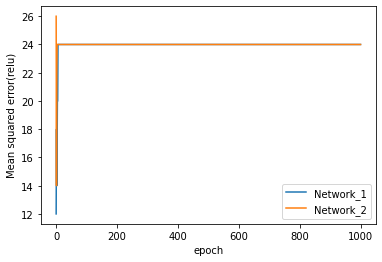

In [14]:
i = range(n_epoch)
plt.plot(i, Loss_1)
plt.plot(i, Loss_2)
plt.legend(['Network_1', 'Network_2'])
plt.xlabel('epoch')
plt.ylabel('Mean squared error(relu)')
plt.show()

In [ ]:
print(y_1)
print(y_2)
print(SL)

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1.  1. -1. -1. -1. -1.  1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[ 1 -1 -1  1  1 -1 -1  1 -1  1]
 [ 1  1 -1 -1  1 -1 -1 -1 -1  1]]
